<a href="https://colab.research.google.com/github/LintangAprillya/Machine-Learning_Semester5/blob/main/Machine%20Learning%20-%20Jobsheet_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

 **Job Sheet 10: Recurrent Neural Network (RNN)**

---


---



---

Nama  : Lintang Aprillya Sari

Kelas : 3C

Absen : 13

NIM   : 2241720231

---



---



# **Praktikum 1**

##**Setup**

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

**Keterangan :**
- Mengimpor library yang diperlukan seperti numpy, tensorflow_datasets, tensorflow, dan matplotlib untuk memvisualisasikan hasil.
- plot_graphs adalah fungsi pembantu untuk memplot grafik accuracy dan loss selama pelatihan dan validasi.

##**Setup Input Pipeline**

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:



In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'I wasn\'t at all a fan of the 2005 gore fest hit "Hostel", and most of these lame ass knock-offs are just as bad or worse - yet "Live Feed" managed to keep me somewhat entertained for about the first 30 minutes. Started off with plenty of sex and sleazy settings, followed by some good death scenes involving the Chinese Organized Crime Squad and a 7-foot, leather-aproned butcher... What put me out of the movie was the tough \'hero\' with the guns and a grudge saving the day... I would call this movie mediocre, at best, since a premise mainly involving obnoxious young people being slaughtered in a seedy porno theater, doubling as a hideout for the mafia, is appealing to me. If only the torture was prolonged enough to be thoroughly effective, then my rating would have differed greatly. Unfortunately, most of the gruesomeness is heaped together in one scene, leaving the rest of the movie to conclude as a revenge-type scenario. So, basically, it IS just a low-budget "Hostel" rip-

**Keterangan :**
- Menggunakan dataset ulasan film IMDB dari tensorflow_datasets (tfds), yang merupakan dataset klasifikasi biner untuk sentimen positif dan negatif.
- Memisahkan dataset menjadi train_dataset dan test_dataset.
- Mengacak dan membagi dataset menjadi batch untuk pelatihan, menggunakan BUFFER_SIZE dan BATCH_SIZE.

##**Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [ ]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [ ]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 10, 268,  31, ...,   0,   0,   0],
       [369,   5,  17, ...,   0,   0,   0],
       [ 45, 825, 122, ..., 469, 714,  73]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I wasn\'t at all a fan of the 2005 gore fest hit "Hostel", and most of these lame ass knock-offs are just as bad or worse - yet "Live Feed" managed to keep me somewhat entertained for about the first 30 minutes. Started off with plenty of sex and sleazy settings, followed by some good death scenes involving the Chinese Organized Crime Squad and a 7-foot, leather-aproned butcher... What put me out of the movie was the tough \'hero\' with the guns and a grudge saving the day... I would call this movie mediocre, at best, since a premise mainly involving obnoxious young people being slaughtered in a seedy porno theater, doubling as a hideout for the mafia, is appealing to me. If only the torture was prolonged enough to be thoroughly effective, then my rating would have differed greatly. Unfortunately, most of the gruesomeness is heaped together in one scene, leaving the rest of the movie to conclude as a revenge-type scenario. So, basically, it IS just a low-budget "Hostel" ri

**Keterangan :**
- Membuat lapisan TextVectorization untuk memproses teks mentah menjadi token.
encoder.adapt digunakan untuk menyiapkan kosakata dari dataset pelatihan.
- Mengecek kosakata dengan encoder.get_vocabulary(), yang mengurutkan kata berdasarkan frekuensi.

##**Buat Model**

diagram model dapat dilihat pada gambar diatas

1. Model ini dapat dibuat sebagai tf.keras.Sequential.

2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.

3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.

4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
  - Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
  - Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
  - Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.

5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [ ]:
# Membuat model Sequential
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [ ]:
# Cek apakah setiap layer mendukung masking
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [ ]:
# Prediksi pada teks sampel tanpa padding
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
encoded_sample = encoder(tf.constant([sample_text]))  # Encode dengan tf.constant

Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [ ]:
# Contoh prediksi dengan padding
padding = "the " * 2000
sample_texts = [sample_text, padding]

# Menggunakan tf.constant untuk memastikan kompatibilitas
predictions = model.predict(tf.constant(sample_texts))
print(predictions[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[-0.01885876]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

##**Train Model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 718s 2s/step - accuracy: 0.5179 - loss: 0.6789 - val_accuracy: 0.7542 - val_loss: 0.5016
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 727s 2s/step - accuracy: 0.7990 - loss: 0.4385 - val_accuracy: 0.8464 - val_loss: 0.3371
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 712s 2s/step - accuracy: 0.8446 - loss: 0.3451 - val_accuracy: 0.8667 - val_loss: 0.3159
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 698s 2s/step - accuracy: 0.8561 - loss: 0.3241 - val_accuracy: 0.8552 - val_loss: 0.3434
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 745s 2s/step - accuracy: 0.8591 - loss: 0.3235 - val_accuracy: 0.8552 - val_loss: 0.3208
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 752s 2s/step - accuracy: 0.8622 - loss: 0.3122 - val_accuracy: 0.8516 - val_loss: 0.3291
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 737s 2s/step - accuracy: 0.8654 - loss: 0.3064 - val_accuracy: 0.8646 - val_loss: 0.3208
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/step - accuracy: 0.8676 - loss: 0.3059 - val_accu

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 157s 402ms/step - accuracy: 0.8631 - loss: 0.3176
Test Loss: 0.3167342245578766
Test Accuracy: 0.8628399968147278


(0.0, 0.6543217301368713)

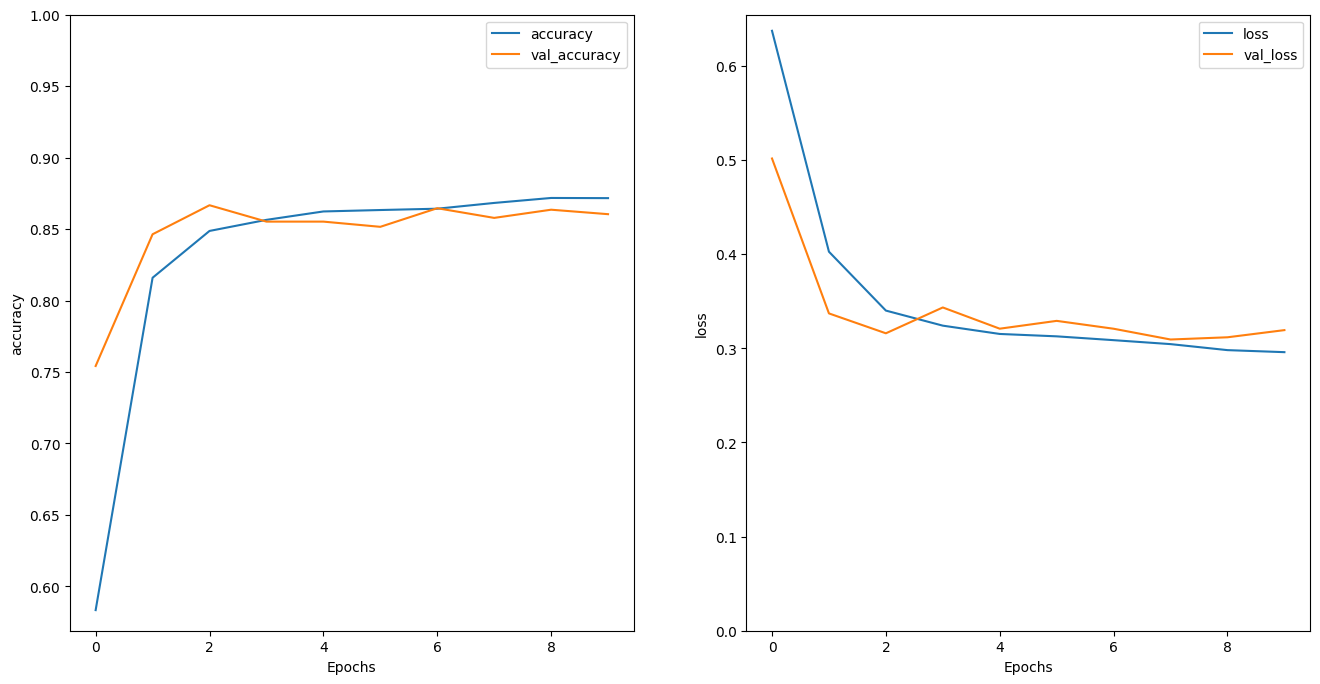

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Pastikan input berbentuk tensor agar kompatibel dengan model
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
[0.4975122]


##**Stack Two or More LSTM Layers**

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :

- Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.

- Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [ ]:
model = tf.keras.Sequential([
     encoder,
     tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1358s 3s/step - accuracy: 0.5186 - loss: 0.6798 - val_accuracy: 0.7052 - val_loss: 0.5199
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1402s 3s/step - accuracy: 0.7848 - loss: 0.4552 - val_accuracy: 0.8589 - val_loss: 0.3461
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1408s 3s/step - accuracy: 0.8501 - loss: 0.3556 - val_accuracy: 0.8594 - val_loss: 0.3264
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1352s 3s/step - accuracy: 0.8547 - loss: 0.3408 - val_accuracy: 0.8349 - val_loss: 0.3407
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1388s 3s/step - accuracy: 0.8625 - loss: 0.3213 - val_accuracy: 0.8578 - val_loss: 0.3239
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1383s 4s/step - accuracy: 0.8640 - loss: 0.3151 - val_accuracy: 0.8068 - val_loss: 0.3643
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1368s 3s/step - accuracy: 0.8663 - loss: 0.3118 - val_accuracy: 0.8495 - val_loss: 0.3159
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1352s 3s/step - accuracy: 0.8695 - loss: 0.2998 - 

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 287s 736ms/step - accuracy: 0.8435 - loss: 0.3228
Test Loss: 0.3228374421596527
Test Accuracy: 0.8423200249671936


In [ ]:
sample_text = ['The movie was cool. The animation and the graphics ',
              'were out of this world. I would recommend this movie.']
text_tensor = tf.convert_to_tensor(sample_text)
predictions = model.predict(text_tensor)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[0.6861654]
 [0.0235871]]


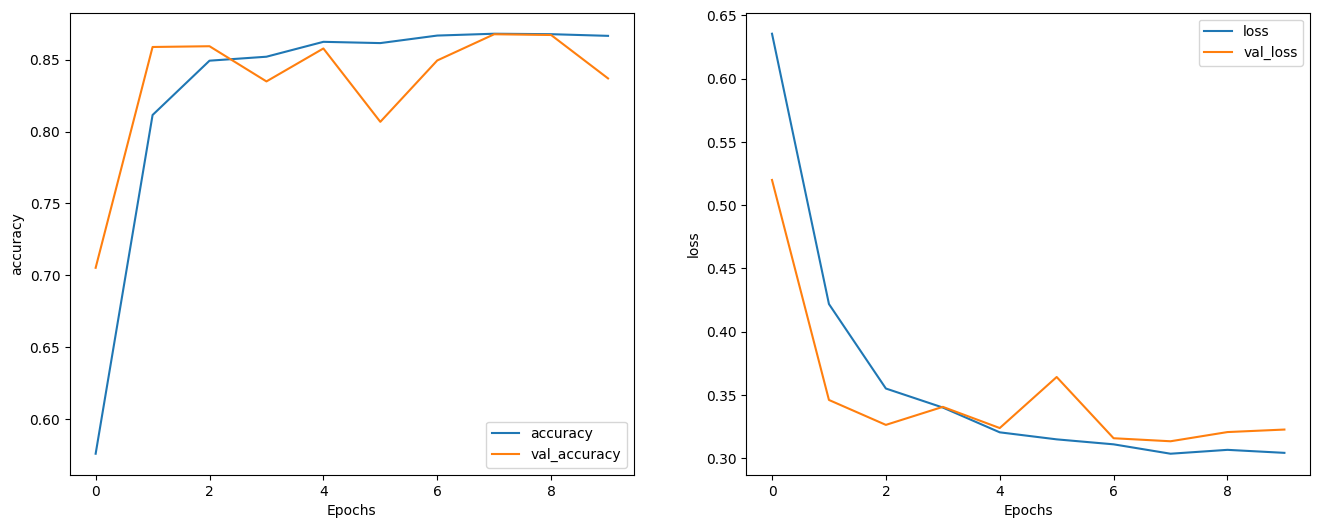

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# **Praktikum 2**

## **Setup**

### Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

### Download Dataset Shakespeare

Sesuaikan dengan lokasi data yang Anda punya.

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


### Load Data

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## **Olah Teks**

### Vectorize Teks

Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. tf.keras.layers.StringLookup dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [ ]:

example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat tf.keras.layers.StringLookup layer:

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

perintah diatas mengconvert token menjadi id

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode tf.keras.layers.StringLookup(..., invert=True).

Catatan: pada kode ini, daripada meneruskan kosakata asli yang dihasilkan dengan diurutkan(set(teks)) gunakan metode get_vocabulary() dari tf.keras.layers.StringLookup sehingga token [UNK] disetel dengan cara yang sama.

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter tf.RaggedTensor:

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Anda dapat menggunakan tf.strings.reduce_join untuk menggabungkan kembali karakter menjadi string.

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### Prediksi

Diberikan sebuah karakter, atau serangkaian karakter, karakter apa yang paling mungkin berikutnya? Ini adalah tugas yang harus Anda latih agar model dapat melakukannya. Masukan ke model akan berupa urutan karakter, dan Anda melatih model untuk memprediksi keluaran berupa karakter berikut pada setiap langkah waktu. Karena RNN mempertahankan keadaan internal yang bergantung pada elemen yang terlihat sebelumnya, mengingat semua karakter dihitung hingga saat ini, karakter apa selanjutnya?

### Membuat Trainin Set dan Target

Selanjutnya bagilah teks menjadi contoh sequence. Setiap masukan sequence akan berisi karakter seq_length dari teks. Untuk setiap masukan sequence, target prediksi berisi teks dengan panjang yang sama, hanya digeser satu karakter ke kanan. Jadi, bagi teks menjadi beberapa bagian seq_length+1. Misalnya, seq_length adalah 4 dan teks kita adalah "Hello". Urutan masukannya adalah "Hell", dan urutan targetnya adalah "ello". Untuk melakukan ini, pertama-tama gunakan fungsi tf.data.Dataset.from_tensor_slices untuk mengonversi vektor teks menjadi aliran indeks karakter.

In [ ]:

all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:

In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Untuk pelatihan, Anda memerlukan kumpulan data pasangan (input, label). Dimana input dan label merupakan urutan. Pada setiap langkah waktu, inputnya adalah karakter saat ini dan labelnya adalah karakter berikutnya. Berikut adalah fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu:

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Membuat Batch Training

Anda menggunakan tf.data untuk membagi teks menjadi sequence yang dapat diatur. Namun sebelum memasukkan data ini ke dalam model, Anda perlu mengacak data dan mengemasnya ke dalam batch.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## **Buat Model**

Bagian ini mendefinisikan model sebagai subkelas keras.Model (untuk lebih detilnya, lihat Making new Layers and Models via subclassing).

Model yang kita bangun memiliki 3 lapisan neural network :

- tf.keras.layers.Embedding: Lapisan masukan. Tabel pencarian yang dapat dilatih yang akan memetakan setiap karakter-ID ke vektor dengan dimensi embedding_dim;

- tf.keras.layers.GRU: lapisan RNN dengan ukuran unit=rnn_units (Anda juga dapat menggunakan lapisan LSTM di sini.)

- tf.keras.layers.Dense: Lapisan keluaran, dengan keluaran vocab_size. Ini menghasilkan satu logit untuk setiap karakter dalam kosakata. Ini adalah log kemungkinan setiap karakter menurut model.

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## **Uji Model**

Coba jalankan model dan cek apakah sidah sesuai dengan output

pertama, cek bentuk dari output

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


Dalam contoh di atas, panjang urutan masukan adalah 100 tetapi model dapat dijalankan pada masukan dengan panjang berapa pun:

In [ ]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  16896     
                                                                 
 gru_1 (GRU)                 multiple                  3938304   
                                                                 
 dense_1 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Untuk mendapatkan prediksi aktual dari model, Anda perlu mengambil sampel dari distribusi keluaran, untuk mendapatkan indeks karakter aktual. Distribusi ini ditentukan oleh logit pada kosakata karakter. Catatan: Penting untuk mengambil sampel dari distribusi ini karena mengambil argmax dari distribusi tersebut dapat dengan mudah membuat model terjebak dalam infinote loop. Cobalah untuk contoh pertama di batch:

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0],num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Hal ini memberi kita, pada setiap langkah waktu, prediksi indeks karakter berikutnya:

In [ ]:
sampled_indices

array([42, 58, 52,  6, 30, 37, 40, 13, 43, 57, 34, 54, 48, 57,  1, 65, 41,
       11, 34, 20, 48, 22, 27,  1, 23, 45,  8, 39, 30, 44, 53, 47, 49,  1,
       34, 34, 60, 56, 59, 44,  5, 10, 25, 30, 40, 41, 39,  0,  4, 14, 65,
       14, 39, 32, 33, 43,  9, 31, 13, 15, 18, 57, 20, 57, 47, 19, 33,  9,
       64, 35,  3, 47, 44,  2, 13, 31, 49, 51, 65, 49, 31, 63, 10, 43, 22,
       19, 30, 30, 21, 57, 12, 39, 18, 65, 25, 41, 60,  6, 31, 20])

Dekode kode berikut untuk melihat teks yang diprediksi oleh model tidak terlatih ini:

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b' a commodity of brown paper and old ginger,\nninescore and seventeen pounds; of which he made\nfive ma'

Next Char Predictions:
 b"csm'QXa?drUoir\nzb:UGiIN\nJf-ZQenhj\nUUuqte&3LQabZ[UNK]$AzAZSTd.R?BErGrhFT.yV!he ?RjlzjRx3dIFQQHr;ZEzLbu'RG"


## **Train Model**

Pada titik ini permasalahan dapat dianggap sebagai permasalahan klasifikasi standar. Permasalahan dapat disimpulkan dengan : Berdasarkan status RNN sebelumnya, dan masukan langkah kali ini, prediksi kelas karakter berikutnya.

### Tambahkan Optimizer dan Fungsi Loss

loss function tf.keras.losses.sparse_categorical_crossentropy standar berfungsi dalam kasus ini karena diterapkan di seluruh dimensi terakhir prediksi. Karena model Anda mengembalikan logits, Anda perlu mengatur flag from_logits.

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1897316, shape=(), dtype=float32)


Model yang baru diinisialisasi tidak boleh terlalu yakin dengan dirinya sendiri, semua log keluaran harus memiliki besaran yang sama. Untuk mengonfirmasi hal ini, Anda dapat memeriksa bahwa eksponensial dari loss rata-rata harus kira-kira sama dengan ukuran kosakata. Loss yang jauh lebih tinggi berarti model tersebut yakin akan jawaban yang salah, dan memiliki inisialisasi yang buruk:

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.00507

Konfigurasikan prosedur pelatihan menggunakan metode tf.keras.Model.compile. Gunakan tf.keras.optimizers.Adam dengan argumen default dan fungsi loss.

In [ ]:
model.compile(optimizer='adam', loss=loss)

### Konfigurasi Checkpoints

Gunakan tf.keras.callbacks.ModelCheckpoint untuk memastikan bahwa checkpoint disimpan selama pelatihan:

In [ ]:
import os

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Lakukan Proses Training

Agar waktu pelatihan tidak terlalu lama, gunakan 10 epoch untuk melatih model. Di Colab, setel runtime ke GPU untuk pelatihan yang lebih cepat.

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 134s 762ms/step - loss: 2.6905
Epoch 2/20
172/172 [==============================] - 131s 758ms/step - loss: 1.9752
Epoch 3/20
172/172 [==============================] - 135s 781ms/step - loss: 1.6944
Epoch 4/20
172/172 [==============================] - 134s 772ms/step - loss: 1.5352
Epoch 5/20
172/172 [==============================] - 128s 740ms/step - loss: 1.4384
Epoch 6/20
172/172 [==============================] - 129s 746ms/step - loss: 1.3710
Epoch 7/20
172/172 [==============================] - 127s 729ms/step - loss: 1.3187
Epoch 8/20
172/172 [==============================] - 132s 761ms/step - loss: 1.2739
Epoch 9/20
172/172 [==============================] - 133s 765ms/step - loss: 1.2329
Epoch 10/20
172/172 [==============================] - 133s 766ms/step - loss: 1.1929
Epoch 11/20
172/172 [==============================] - 127s 733ms/step - loss: 1.1532
Epoch 12/20
172/172 [==============================] - 131s 754

## **Generate Teks**

Cara termudah untuk menghasilkan teks dengan model ini adalah dengan menjalankannya dalam loop, dan menyimpan status internal model saat Anda menjalankannya.

Setiap kali Anda memanggil model, Anda memasukkan beberapa teks dan state internal. Model mengembalikan prediksi untuk karakter berikutnya dan state barunya. Masukkan kembali prediksi dan state ke model untuk terus menghasilkan teks.

Berikut ini membuat prediksi satu langkah:

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Jalankan secara berulang untuk menghasilkan beberapa teks. Melihat teks yang dihasilkan, Anda akan melihat model mengetahui kapan harus menggunakan huruf besar, membuat paragraf, dan meniru kosakata menulis seperti Shakespeare. Karena sedikitnya jumlah epoch pelatihan, model belum belajar membentuk kalimat runtut.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Out on no, afford shall fell me one of us?

Messenger:
The coverletw, brief with thee! save him, Juliet,
Drawn thy unmet in a gentlinance, turn thy
complaints
And turn you all home an enemy and
Tybaltuful service, write in rogit.
But here his devilible is enough,
Is made thee as a most virtuous.

BAPTISTA:
What, nurse, obeying this? mother, he has none
Senators of a full kill'd; for thou, accords not princely
But ere they were son, so King of York.
Well said, my Lord of Dead Waste ground!'
Your sunatly with my blushing conjurations,
And cere their currer Rutland
Not one against the heart.

ROMEO:
Not what your soul since, I have ended
it thou art poor: to shriek my king and him,
For it encertainy those that fear,
As 'twere I throwledged by with treesbern of the peace.
For herd he slip so well, no day, where Sixtnes
Become the noble Duke on 't, such a
man for meat, give me that thy waych: steal, old York,
Fear not thy labour and the white o' the city?
Letce feed their voices, nor

Hal termudah yang dapat Anda lakukan untuk meningkatkan hasil adalah dengan melatihnya lebih lama (coba EPOCHS = 30). Anda juga dapat bereksperimen dengan string awal yang berbeda, mencoba menambahkan lapisan RNN lain untuk meningkatkan akurasi model, atau menyesuaikan parameter suhu untuk menghasilkan prediksi yang kurang lebih acak.

Jika Anda ingin model menghasilkan teks lebih cepat, hal termudah yang dapat Anda lakukan adalah membuat teks secara batch. Pada contoh di bawah, model menghasilkan 5 keluaran dalam waktu yang hampir sama dengan waktu yang dibutuhkan untuk menghasilkan 1 keluaran di atas.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nI shall here is our field: on whom declining vew\nDrop'ding their hearts. The subjects now\nBut send the friar too tell them your for usurel;\nAnd thy soul's person; he not right here dividement\nAs Anne their winds.'\n\nKING RICHARD III:\nHave you gone, if my wounds are o?\n\nISABELLA:\n\nSecond Citizen:\nAnd then we do, sir, for I say yet and no more.\nAh, here I take her hence to follow me;\nPatience is rippish'd, say I swear Jupt's\nSolemn to besiege and till your grace\nShould come of the sentence, my glorious pursuit.\n\nHENRY BOLINGBROKE:\nTears, good night.\nI have seen them but we touch'd his fleed\nMay seem'd with vain. O place, my lord\nAno holy manner more than a poxkn of the earth.\n\nOXFORD:\nI know her, nurse, to all green cried,\nAdd neither for my brother breath,\nAnd not prepared for length. My brother Gloucester,\nand see our leaves unleep thy deare; and his noble ser;\nIf the bear by the streets thy brothers brooch\nBlind it become her cheeks n

## **Ekspor Model Generator**

Model satu langkah ini dapat dengan mudah disimpan dan digunakan kembali, memungkinkan Anda menggunakannya di mana pun tf.saved_model diterima.


In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Where then she speaks you three o' the rept.
If that be nug,'--which was done fell.

BIANCA:
He can


# **Tugas**

Prosedur pelatihan pada praktikum 2 merupakan prosedur sederhana, yang tidak memberi Anda banyak kendali. Model ini menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan. Jadi, setelah Anda melihat cara menjalankan model secara manual, selanjutnya Anda akan mengimplementasikan custom loop pelatihan. Hal ini memberikan titik awal jika, misalnya, Anda ingin menerapkan pembelajaran kurikulum untuk membantu menstabilkan keluaran open-loop model. Bagian terpenting dari loop pelatihan khusus adalah fungsi langkah pelatihan.

Gunakan tf.GradientTape untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca eager execution guide.

Prosedurnya adalah :

1. Jalankan Model dan hitung loss dengan tf.GradientTape.

2. Hitung update dan terapkan pada model dengan optimizer

**Jawab :**

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [ ]:
for char in vocab:
    print(char, end=' ')


   ! $ & ' , - . 3 : ; ? A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z 

**olah Teks**

Vectorize Teks

Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. tf.keras.layers.StringLookup dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
#  buat tf.keras.layers.StringLookup layer:

ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

**Prediksi**

Membuat Training Set dan Target

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100
#batch memungkinkan kita dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


**Membuat Batch Training**

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

**Uji Model**

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru_2 (GRU)                 multiple                  3938304   
                                                                 
 dense_2 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0],num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([32, 33, 23, 18, 42,  8, 51, 42, 43, 29, 35, 55, 22, 10,  8, 29, 60,
       12, 31, 28, 49, 47, 65, 41, 49,  5,  0, 18, 18, 58, 51, 54,  0, 30,
       20, 33, 41,  9, 31, 39, 29, 29, 17, 59, 25, 33, 30, 25, 21, 39, 48,
       24, 51,  9, 10,  2, 65, 16, 16, 36,  8, 33,  0, 56, 64,  5, 21, 65,
       46, 63,  2, 53, 53, 26, 37, 19, 33, 15, 62, 52, 24, 60, 12,  5, 34,
       25, 30, 49, 29, 60,  3, 52,  5, 36, 12, 63, 36, 20, 27, 12])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'r pupils presently.\nHolla, within!\nSirrah, lead these gentlemen\nTo my daughters; and tell them both,'

Next Char Predictions:
 b'STJEc-lcdPVpI3-Pu;ROjhzbj&[UNK]EEslo[UNK]QGTb.RZPPDtLTQLHZiKl.3 zCCW-T[UNK]qy&Hzgx nnMXFTBwmKu;&ULQjPu!m&W;xWGN;'


**Train Model**

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1900253, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.02446

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS = 10
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 130s 743ms/step - loss: 2.7394
Epoch 2/10
172/172 [==============================] - 132s 764ms/step - loss: 1.9923
Epoch 3/10
172/172 [==============================] - 128s 737ms/step - loss: 1.7205
Epoch 4/10
172/172 [==============================] - 127s 733ms/step - loss: 1.5611
Epoch 5/10
172/172 [==============================] - 127s 733ms/step - loss: 1.4611
Epoch 6/10
172/172 [==============================] - 127s 733ms/step - loss: 1.3920
Epoch 7/10
172/172 [==============================] - 130s 750ms/step - loss: 1.3390
Epoch 8/10
172/172 [==============================] - 131s 754ms/step - loss: 1.2940
Epoch 9/10
172/172 [==============================] - 127s 730ms/step - loss: 1.2538
Epoch 10/10
172/172 [==============================] - 132s 760ms/step - loss: 1.2143


In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
My suddest water, darging noble ordare!
Sin that I heard him more should friends;
The nardon feed is none in late be the
thrin down, looking occasion for a prefer
Will untrue my peril of a man with me to the
Which our hours is three land and eyest
Than fly to saint. O, if I promised,
I would not in the rinator Lost this knightly more
Than we are sudden ouphation here shall
Stone hearts come to know our tale. I promised ere
Be patient and the remain as deed,
follow living for a smility-citizens.

Provost:
Wouldst thou kill the rest wear behind to your love.

KATHARINA:
I know his tongue, and mocky bounts unto revise.
The dake of English fore-blood paying go
Why our counsels by, sir; what wit may banish
in them, nay, but so fire absent him; for I were soil
The end o' the light and gold be gone to thy woman's!
He is no round in queen and law, and rebell'd
By height on bodied gloss, would show my mindhems,
With plame men, away! O, sir, the prince: all toes pronounce the sin.

NORTHU

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nRomeo, grandam, the like a this man's birth,\nWhich right wears, and eyms and eyes\nor words men and help him to come so high as mistress mount,\nBut we resolved thee in my brother's foot.\n\nPayar:\nMy lord, I do; say, you mean to leave\nEdward for us and be thither: on our peers,\nAnd she ends she should tell the world's grievy,\nTakes reputy now to poor wilt that ore\nAll mourners 'shall.' Richard; come to you.\n\nAUTOLYCUS:\nGood me laugh to this.\n\nCOMINIUS:\nWell thou the little, three-shall be fourteen.\nMy Lord Nor he would blown sweet carban:\nAn he hath ready and let no more that Claudio\nTwill this be brought for it on me;\nAnd I action both you, 'tis this.\n\nQUEEN ELIZABETH:\nBrother out? we'll sweat to your eleves! hath absent husbining steals. Accern to kills us Sun wo?\nThis is your friend enough to be gone,\nWhich expess old brown of them but ready, and\nSaf shall I make; while we stwalling raised in love,\nEnvious me to spain and pate: Paulina l

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Would I do condit, and knows with him.

MENENIUS:
Being altogether in the poes
guessporn'd by death




---


**Tugas**

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 130s 733ms/step - loss: 2.7358


In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
  start = time.time()

  mean.reset_states()
  for (batch_n, (inp, target)) in enumerate(dataset):
    logs = model.train_step([inp, target])
    mean.update_state(logs['loss'])

    if batch_n % 50 == 0:
      template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
      print(template)

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))

  print()
  print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
  print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
  print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1996
Epoch 1 Batch 50 Loss 2.0444
Epoch 1 Batch 100 Loss 1.9380
Epoch 1 Batch 150 Loss 1.8620

Epoch 1 Loss: 2.0026
Time taken for 1 epoch 129.95 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8246
Epoch 2 Batch 50 Loss 1.7962
Epoch 2 Batch 100 Loss 1.7069
Epoch 2 Batch 150 Loss 1.6473

Epoch 2 Loss: 1.7184
Time taken for 1 epoch 128.82 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6054
Epoch 3 Batch 50 Loss 1.5956
Epoch 3 Batch 100 Loss 1.5796
Epoch 3 Batch 150 Loss 1.5232

Epoch 3 Loss: 1.5539
Time taken for 1 epoch 126.85 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4541
Epoch 4 Batch 50 Loss 1.4606
Epoch 4 Batch 100 Loss 1.4728
Epoch 4 Batch 150 Loss 1.3912

Epoch 4 Loss: 1.4540
Time taken for 1 epoch 128.11 sec
_________________________________________________________________

Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?


**Jawab :**

Pada praktikum 2, pelatihan model dilakukan dengan metode model.fit(), yang merupakan cara pelatihan standar dan sering digunakan karena kesederhanaannya. Sebaliknya, dalam kode tugas, pelatihan model menggunakan pendekatan yang lebih kompleks dan terperinci, dengan sejumlah kustomisasi.

Pada pendekatan yang lebih mendetail ini, metode train_step() didefinisikan dalam model turunan, yang memungkinkan pengaturan pelatihan pada level batch. Dalam metode ini, loss dihitung, gradien diambil, dan pembaruan bobot model dilakukan menggunakan apply_gradients(). Selain itu, objek tf.metrics.Mean() digunakan untuk menghitung rata-rata loss selama pelatihan. Pendekatan ini memberikan kontrol yang lebih besar dan fleksibilitas lebih tinggi dalam mengatur proses pelatihan model.